In [1]:
import numpy as np
import os
import itertools
from collections import defaultdict
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.append("../utils")
sys.path.append("../")
import utils.util_lookup_table
# import utils.util_data
from pprint import pprint

In [2]:
[f[:-4] for f in os.listdir("./results")]
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# Global Styles

In [3]:
color = defaultdict(lambda: np.random.choice(['k','r','b','purple', 'periwinkle']), {
 'QPSK_classic_and_neural':"r",
 'QPSK_neural_vs_clone':"r",
 'QPSK_neural_and_neural':"g",
 'QPSK_neural_vs_selfalien':'g',
 'QPSK_neural_and_classic':"b",
 'QPSK_neural_vs_poly':'y',
 'QPSK_neural_vs_classic':"orange",
 'QPSK_poly_vs_clone':"blue",
})

STYLE_POOL = list(itertools.product(
        [1, 0.8],
        ['solid', (0, (7, 3)), (0, (1, 1)), (0, (3, 1))], 
        ['b', 'purple', 'r', 'k']))
# np.random.shuffle(STYLE_POOL)
# STYLE_DICT = defaultdict(lambda: STYLE_POOL.pop(0))
class StyleDict():
    def __init__(self):
        self.palette = [
            "#922b21",
            "#e74c3c",
            "#6c3483",
            "#9b59b6",
            "#1f618d",
            "#3498db"]
        
    def __getitem__(self, key):
        key = key.lower()
        # EPP Stylings
        if 'neural' in key and 'poly' in key:
            m = 1
        elif 'neural' in key:
            m = 0
        elif 'poly' in key:
            m = 2
        else:
            raise NotImplemented
        if 'classic' in key:
            color = self.palette[m * 2 + 1]
        else:
            color = self.palette[m * 2]
        if 'fast' in key and 'slow' in key:
            style = (0, (1, 1))
        elif 'fast' in key:
            style = 'solid'
        elif 'slow' in key:
            style = (0, (3, 1))
        elif 'gp' in key or 'snr' in key:
            style = ':'  # will be replaced below
        else:
            raise NotImplemented
        darken = 1.0
        # Stylings for multi-protocol trials
        if 'private' in key:
            style = 'solid'
            color = self.palette[0]
        if 'shared' in key:
            style = (0, (3, 1))
            color = self.palette[2]
        if 'loss' in key:
            style = (0, (1, 1))
            color = self.palette[4]
        if 'gradient' in key:
            style = (0, (7, 3))
            color = 'k'
        # Stylings for mod order trials
        if 'qpsk' in key:
            style = 'solid'
            color = self.palette[0]
        if '8psk' in key:
            style = (0, (3, 1))
            color = self.palette[2]
        if 'qam16' in key:
            style = (0, (1, 1))
            color = self.palette[4]
        # Stylings for SNR trials
        if 'db' in key and 'high' in key:
            style = 'solid'
            color = self.palette[4]
        elif 'db' in key and 'low' in key:
            style = (0, (1, 1))
            color = self.palette[0]
        elif 'db' in key:
            style = (0, (3, 1))
            color = self.palette[2]
        return darken, style, color
STYLE_DICT = StyleDict()
LINE_STYLES = lambda k: STYLE_DICT[k][1]
DARKEN_BY = lambda k: STYLE_DICT[k][0]
COLORS = lambda k: STYLE_DICT[k][2]
# LINE_STYLES = defaultdict(lambda: np.random.choice(['solid', (0, (7, 3)), (0, (1, 1)), (0, (3, 1))]), {
#                'neural_vs_poly': (0, (7, 3)),
#                'poly_vs_clone':(0, (1, 1)),
#                'neural_vs_clone':'solid',#(0, (2, 7)),
#                'neural_vs_selfalien':'solid',
#                'neural_vs_selfalien_ppo':'solid',
#                'neural_vs_selfalien_ppo_minibatch':'solid',
#                'neural_vs_classic': 'solid',
#                'neural_and_classic': 'solid',
#                'large_256_maml': (0, (7, 3))
#               })
# DARKEN_BY = defaultdict(lambda: np.random.choice([1, .9, .8, .6]), {
#                'neural_vs_poly':1,
#                'poly_vs_clone':1,
#                'neural_vs_clone':1,
#                'neural_vs_selfalien':.5,
#                'neural_vs_selfalien_ppo':.9,
#                'neural_vs_selfalien_ppo_minibatch':.8,
#                'neural_vs_classic':0.8,
#                'neural_and_classic':0.8,
#                'large_256_maml': 0.8
#             })

# COLORS = defaultdict(lambda: np.random.choice(['k','r','b','purple', 'g']), {
#                'neural_vs_poly':'purple',
#                'poly_vs_clone':'r',
#                'neural_vs_clone':'b',
#                'neural_vs_selfalien':'b',
#                'neural_vs_selfalien_ppo':'purple',
#                'neural_vs_selfalien_ppo_minibatch':'r',
#                'neural_vs_classic':'g',
#                'neural_and_classic':'g',
#                'large_256_maml': 'b'
#             })

MOD_ORDERS = {2: "QPSK", 3: "8PSK", 4: "QAM16"}
MOD2BPS = {'QPSK': 2, '8PSK': 3, 'QAM16': 4}

In [4]:
def plot_ber_and_fraction_trials(includes, excludes, bps=None, log_scale=False, 
                                 right=0, k=0, snr=None, 
                                 keep_protocol=False, keep_order=False, keep_snr=False,
                                 titletext=""):
    _bps=bps
    _snr=snr
    br = utils.util_lookup_table.BER_lookup_table()
    plt.style.use('seaborn-ticks')

    # fig,(ber, db3, db5) = plt.subplots(3, 1)
#     fig,(ber, db3) = plt.subplots(2, 1)
#     fig.set_figheight(4.5*2)
#     fig.set_figwidth(6)
    ber = plt.figure()
    db3 = plt.figure()
    ber.set_figheight(4.5)
    db3.set_figheight(4.5)
    ber.set_figwidth(6)
    db3.set_figwidth(6)
    # for ax in axes:
    #     ax.set_aspect('equal', adjustable="datalim")
    # (ber, db3, db5) = axes
    # fig.suptitle('Private w/ QPSK at 8.4dB Training SNR')
    baseline=defaultdict(lambda: False)
    for experiment_name in sorted(os.listdir("./results/")):
        if (not all([_ in experiment_name for _ in must_include])) \
            or any([_ in experiment_name for _ in must_exclude]):
            continue
        print(experiment_name)
        k+=1
        f = os.path.join("./results", experiment_name)
        models = "_".join(experiment_name[:-4].split("_")[3:])
        protocol = "_".join(experiment_name[:-4].split("_")[:2])
        print(models)
        order = experiment_name[:-4].split("_")[2]
        if bps is None:
            _bps = MOD2BPS[order]
            print("Using BPS={} for mod_order {}".format(_bps, order))
        # snr = float(snr.replace("_","."))
        r = np.load(f, allow_pickle=True).item()  
#         print(r)
        # snr = 8.4
        try:
            if snr is None:
                _snr = sorted(r.keys())[0]
                print("Using lowest SNR {}".format(_snr))
            r = r[_snr]
        except KeyError as e:
            print("Available SNRs: {}".format(list(r.keys())))
            raise e
        # Set axis limits
        if right == 0 or r['symbols_sent'][-1] > right:
            right = r['symbols_sent'][-1] * 2 - r['symbols_sent'][-2]
        experiment_name = experiment_name[:-4]
        print(protocol, experiment_name, _snr)
        fs_x = np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]
        # print(r['test_SNR_dbs'])
        fs_mid = np.fliplr(np.array(r['BER_mid']).reshape((1, 6)))[0]
        fs_low = np.fliplr(np.array(r['BER_low']).reshape((1, 6)))[0]
        fs_high = np.fliplr(np.array(r['BER_high']).reshape((1, 6)))[0]
        if keep_protocol:
            ckey = protocol + models
        elif keep_order:
            ckey = order + models
        elif keep_snr:
            ckey = "db" + models
        else:
            ckey = models
        dkey=ckey# protocol + models if keep_protocol else order + models if keep_order else models
        lkey=ckey# protocol + models if keep_protocol else order + models if keep_order else models
        inset = True
        # label = ", ".join([models, protocol]).replace("_", " ")
        if keep_protocol:
            label = protocol + "_" + models
        elif keep_order:
            label = order + "_" + models
        elif keep_snr:
            label = "{}_dB_SNR_".format(_snr) + models
        else:
            label = models
        label=label.replace("_", " ").title().replace(
            "Vs", "and").replace(
            "Ppo", "PPO").replace(
            "Pg", "PG").replace(
            "Sgd", "SGD").replace(
            "Gradient Passing", "GP").replace(
            "Loss Passing", "LP").replace(
            "Shared Preamble", "ESP").replace(
            "Private Preamble", "EPP").replace(
            "Qpsk", "QPSK").replace(
            "8Psk", "8PSK").replace(
            "Qam16", "QAM16").replace(
            "Snr", "SNR").replace(
            "Db", "dB").replace(
            " Fast", "-fast").replace(
            " Slow", "-slow").replace(
            " High SNR", "").replace(
            " Low SNR", "").replace(
            " Gp", "")
        # print(fs_mid)
        # print(fs_low)
        # print(fs_high)
        ber.gca().errorbar(
                        np.array(fs_x) + k*1e-1, 
                        fs_mid,  
                        yerr = [fs_mid - fs_low, fs_high- fs_mid], 
                        elinewidth = 2, 
                        linestyle = LINE_STYLES(lkey),
                        color = lighten_color(COLORS(ckey), amount=DARKEN_BY(dkey)),
                        #fmt = 'o-', 
                        label=label,
                        linewidth = 3,
                        alpha = .80,# if LINE_STYLES(lkey) == "solid" else 1.0,
                    )
        if log_scale:
            symbols_sent =  np.array([r['symbols_sent'][0] / 4] + r['symbols_sent'] + [right])
        else:
            symbols_sent = [0.0] + r['symbols_sent'] + [right]
        db3.gca().plot(symbols_sent, 
                 np.concatenate(([0.0],r['3db_off'],r['3db_off'][-1:])),'o-',
                        linestyle = LINE_STYLES(lkey),
                        color = lighten_color(COLORS(ckey), amount=DARKEN_BY(dkey)),
                        label=label,
                        linewidth = 3,
                        alpha=(.80),# if LINE_STYLES(lkey) == "solid" else 1.0),
                )
    #     db5.plot(symbols_sent, 
    #              np.concatenate(([0.0],r['5db_off'],r['5db_off'][-1:])),'o-',\
    #                     linestyle = LINE_STYLES[lkey],
    #                     color = lighten_color(COLORS[ckey], amount=DARKEN_BY[dkey]),
    #                     label=label,
    #                     linewidth = 3,
    #                     alpha=(.50 if LINE_STYLES[lkey] == "solid" else 1.0),
    #             )
        if not baseline[_bps]:
            ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, _bps) 
                            for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
    #         ber3_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-3, 2) 
    #                         for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
    #         ber5_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-5, 2) 
    #                         for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
            if keep_order:
                linestyle = 'solid' if order == 'QPSK' else (0, (3, 1)) if order == '8PSK' else (0, (1, 1))
            else:
                linestyle = 'solid'
            ber.gca().plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
                  ber_baseline, linestyle=linestyle,#'o-b',
                  label="%s Baseline" % MOD_ORDERS[_bps], color ='gray', linewidth = 3, alpha=1)
    #         ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
    #               ber3_baseline,#'o-b',
    #               label="3db off", color ='gray', linewidth = 3, alpha=.8)
    #         ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
    #               ber5_baseline,
    #               label="5db off", color ='gray', linewidth = 3, alpha=.5)
            baseline[_bps]=True
#     ber.set_aspect('equal')
    ber.gca().set_yscale('log')
    ber.gca().set_title("Median BER Curves")
    ber.gca().set_xlabel('SNR (dB)')
    ber.gca().set_ylabel('Round-trip BER')
    # ber.set_xlim(right=14.0)
    # inset axes....
    # if inset:

    # ber.legend()

    db3.gca().set_ylim(top=1.1, bottom=-0.1)
    # db5.set_ylim(top=1.1, bottom=-0.1)
    # db3.set_xlim(left=0, right=right)
    # db5.set_xlim(left=0, right=right)
    if log_scale:
        db3.gca().set_xscale('log')
        # db5.set_xscale('log')
    # db3.ticklabel_format(axis='both', style='sci')
    # db5.ticklabel_format(axis='both', style='sci')

    db3.gca().set_title("Fraction of Trials within 3 dB")
    db3.gca().set_ylabel('Fraction of Trials Converged within 3 dB')
    db3.gca().set_xlabel('Number of preamble symbols transmitted')

    # db5.set_title("Fraction of seeds within 5db")
    # db5.set_ylabel('Fraction of Trials Converged within 5dB')
    # db5.set_xlabel('Number of preamble symbols transmitted')
    # db5.set_aspect('equal')
    
    # BER legend
    handles, labels = ber.gca().get_legend_handles_labels()
    order = sorted(range(len(labels)),key=labels.__getitem__)
    # order = [order[i] for i in [0,2,1,4,3,5]] 
    # order = [order[i] for i in [0,2,1]] 
    handles = [handles[idx] for idx in order]
    labels = [labels[idx] for idx in order]
    # Put a legend below current axis
    berlgd = ber.gca().legend(handles,                # The line objects
               labels,
               borderaxespad=0.1,    # Small spacing around legend box
    #            title="Protocols and Models",  # Title for the legend
               loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=2 if not keep_snr else 1,
               handlelength=4
               )
#     ber.tight_layout()
    
    # dB3 legend
    handles, labels = db3.gca().get_legend_handles_labels()
    order = sorted(range(len(labels)),key=labels.__getitem__)
    if keep_snr:
        order = range(len(labels))
    # order = [order[i] for i in [0,2,1,4,3,5]] 
    # order = [order[i] for i in [0,2,1]] 
    handles = [handles[idx] for idx in order]
    labels = [labels[idx] for idx in order]
    # Put a legend below current axis
    db3lgd = db3.gca().legend(handles,                # The line objects
               labels,
#                borderaxespad=0.1,    # Small spacing around legend box
    #            title="Protocols and Models",  # Title for the legend
               loc='upper center', bbox_to_anchor=(0.5, -0.15),
               fancybox=True, shadow=True, ncol=2 if not keep_snr else 1,
               handlelength=4
               )
#     db3.tight_layout()
    # fig.subplots_adjust(top=0.85)
#     fig.subplots_adjust(bottom=0.15, hspace = 0.4)  
#     fig.savefig('./alien_tuned.pdf', format = 'pdf', bbox_inches='tight')
    if titletext:
        bertitle = "ber-" + titletext + ".pdf"
        db3title = "db3-" + titletext + ".pdf"
    else:
        bertitle = "ber.pdf"
        db3title = "db3.pdf"
    ber.savefig('figures_journal/' + bertitle, format='pdf', bbox_extra_artists=(berlgd,), bbox_inches='tight')
    ber.show()
    db3.savefig('figures_journal/' + db3title, format='pdf', bbox_extra_artists=(db3lgd,), bbox_inches='tight')
    db3.show()

# Journal Plots

## Plot 1

private_preamble_QPSK_neural_fast_vs_classic.npy
neural_fast_vs_classic
private_preamble private_preamble_QPSK_neural_fast_vs_classic 8.4
private_preamble_QPSK_neural_slow_vs_classic.npy
neural_slow_vs_classic
private_preamble private_preamble_QPSK_neural_slow_vs_classic 8.4
private_preamble_QPSK_poly_fast_vs_classic.npy
poly_fast_vs_classic
private_preamble private_preamble_QPSK_poly_fast_vs_classic 8.4
private_preamble_QPSK_poly_slow_vs_classic.npy
poly_slow_vs_classic
private_preamble private_preamble_QPSK_poly_slow_vs_classic 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


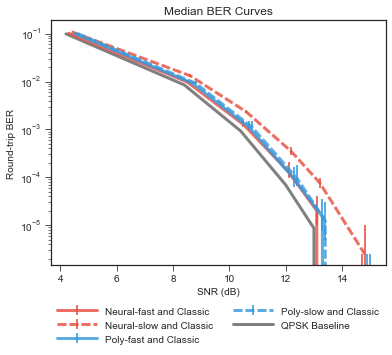

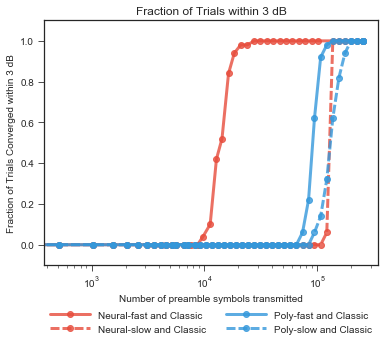

In [5]:
must_include = ['QPSK','private', 'classic']#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = ['pg', 'ppo','snr']#['poly', 'selfalien']
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4,
                             titletext="EPP-classics", right=500*512)

## Plot 2

private_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
private_preamble private_preamble_QPSK_neural_fast_vs_neural_fast 8.4
private_preamble_QPSK_neural_fast_vs_neural_slow.npy
neural_fast_vs_neural_slow
private_preamble private_preamble_QPSK_neural_fast_vs_neural_slow 8.4
private_preamble_QPSK_neural_slow_vs_neural_slow.npy
neural_slow_vs_neural_slow
private_preamble private_preamble_QPSK_neural_slow_vs_neural_slow 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


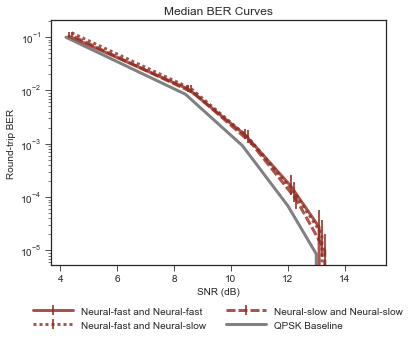

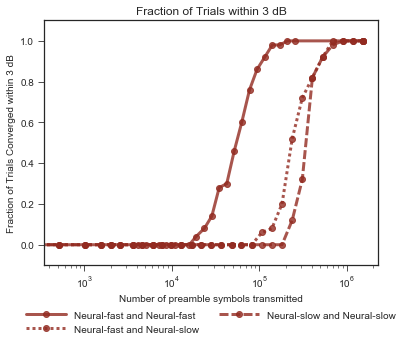

In [6]:
must_include = ['QPSK','private', 'neural']#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = ['pg', 'ppo', 'poly', 'classic', 'clone', 'selfalien','_low','high','snr'] + ["_"+str(i) for i in range(20)]#['poly', 'selfalien']
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4,right=3000*512,
                             titletext="EPP-neurals")

private_preamble_QPSK_poly_fast_vs_poly_fast.npy
poly_fast_vs_poly_fast
private_preamble private_preamble_QPSK_poly_fast_vs_poly_fast 8.4
private_preamble_QPSK_poly_fast_vs_poly_slow.npy
poly_fast_vs_poly_slow
private_preamble private_preamble_QPSK_poly_fast_vs_poly_slow 8.4
private_preamble_QPSK_poly_slow_vs_poly_slow.npy
poly_slow_vs_poly_slow
private_preamble private_preamble_QPSK_poly_slow_vs_poly_slow 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


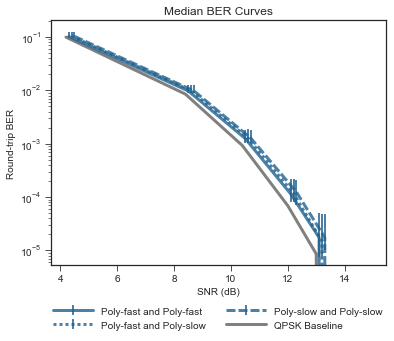

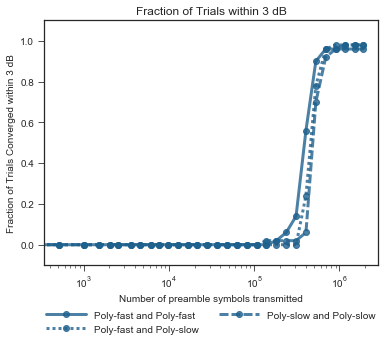

In [7]:
must_include = ['QPSK','private', 'poly']#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = ['pg', 'ppo', 'neural', 'classic', 'clone', 'selfalien','_low','high','snr'] + ["_"+str(i) for i in range(20)]#['poly', 'selfalien']
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4,
                             titletext="EPP-polys")

## Plot 3

private_preamble_QPSK_neural_slow_vs_neural_slow.npy
neural_slow_vs_neural_slow
private_preamble private_preamble_QPSK_neural_slow_vs_neural_slow 8.4
private_preamble_QPSK_neural_slow_vs_poly_fast.npy
neural_slow_vs_poly_fast
private_preamble private_preamble_QPSK_neural_slow_vs_poly_fast 8.4
private_preamble_QPSK_poly_fast_vs_poly_fast.npy
poly_fast_vs_poly_fast
private_preamble private_preamble_QPSK_poly_fast_vs_poly_fast 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


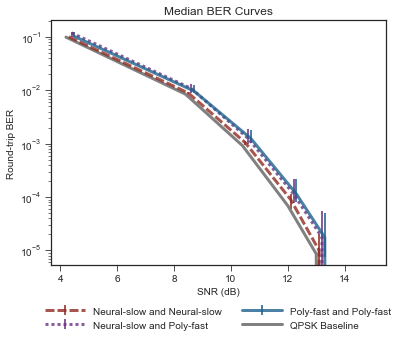

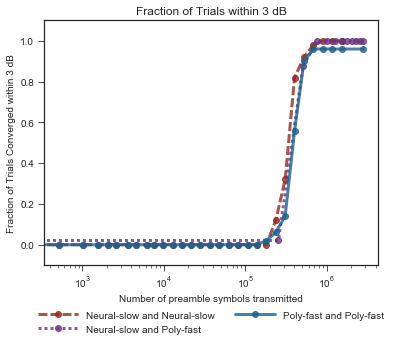

In [8]:
must_include = ['QPSK','private', ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'classic', 'clone', 'selfalien','snr'] + ["_"+str(i) for i in range(20)] +
                ['poly_slow_vs_poly', 'poly_fast_vs_poly_slow', 'neural_fast_vs_neural', 'neural_fast_vs_neural_slow','neural_slow_vs_poly_slow', 'neural_fast_vs_poly_fast', 'neural_fast_vs_poly_slow','_low','high'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4,right=3000*512,
                             titletext="EPP-neural-poly-crosses")

private_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
private_preamble private_preamble_QPSK_neural_fast_vs_neural_fast 8.4
private_preamble_QPSK_neural_fast_vs_poly_slow.npy
neural_fast_vs_poly_slow
private_preamble private_preamble_QPSK_neural_fast_vs_poly_slow 8.4
private_preamble_QPSK_poly_slow_vs_poly_slow.npy
poly_slow_vs_poly_slow
private_preamble private_preamble_QPSK_poly_slow_vs_poly_slow 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


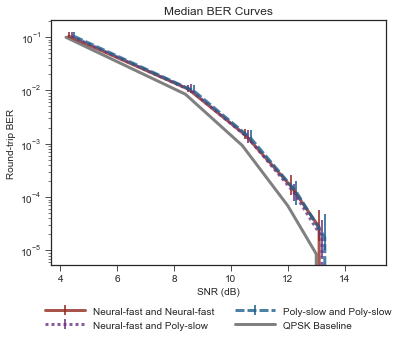

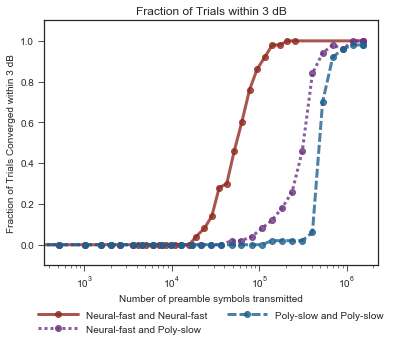

In [9]:
must_include = ['QPSK','private', ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'classic', 'clone', 'selfalien','snr'] + ["_"+str(i) for i in range(20)] +
                ['poly_fast_vs_poly', 'poly_fast_vs_poly_slow', 'neural_slow_vs_neural', 'neural_fast_vs_neural_slow','neural_slow_vs_poly_slow', 'neural_fast_vs_poly_fast', 'neural_slow_vs_poly_fast','_low','high'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4,right=3000*512,
                             titletext="EPP-neural-poly-crosses-gap")

## Plot 5

gradient_passing_QPSK_neural_gp_vs_classic.npy
neural_gp_vs_classic
gradient_passing gradient_passing_QPSK_neural_gp_vs_classic 8.4
loss_passing_QPSK_neural_fast_vs_classic.npy
neural_fast_vs_classic
loss_passing loss_passing_QPSK_neural_fast_vs_classic 8.4
private_preamble_QPSK_neural_fast_vs_classic.npy
neural_fast_vs_classic
private_preamble private_preamble_QPSK_neural_fast_vs_classic 8.4
shared_preamble_QPSK_neural_fast_vs_classic.npy
neural_fast_vs_classic
shared_preamble shared_preamble_QPSK_neural_fast_vs_classic 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


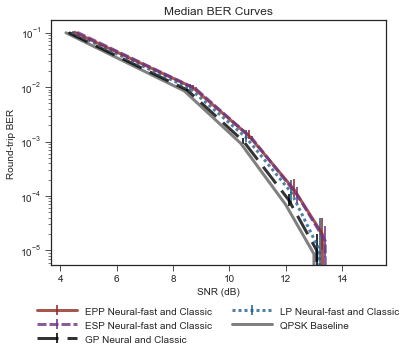

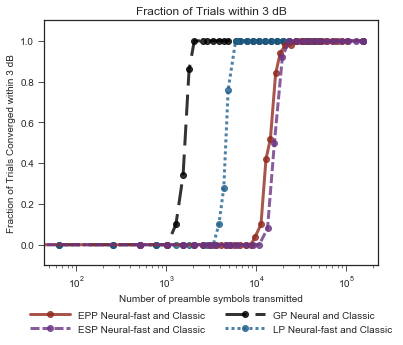

In [10]:
must_include = ['QPSK','neural', 'classic' ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'clone', 'selfalien'] + ["_"+str(i) for i in range(20)] 
                +['_low','high','slow'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4, keep_protocol=True,
                             right=300*512,
                             titletext="allproto-neural-classic")

## Plot 6

gradient_passing_QPSK_poly_gp_vs_classic.npy
poly_gp_vs_classic
gradient_passing gradient_passing_QPSK_poly_gp_vs_classic 8.4
loss_passing_QPSK_poly_fast_vs_classic.npy
poly_fast_vs_classic
loss_passing loss_passing_QPSK_poly_fast_vs_classic 8.4
private_preamble_QPSK_poly_fast_vs_classic.npy
poly_fast_vs_classic
private_preamble private_preamble_QPSK_poly_fast_vs_classic 8.4
shared_preamble_QPSK_poly_fast_vs_classic.npy
poly_fast_vs_classic
shared_preamble shared_preamble_QPSK_poly_fast_vs_classic 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


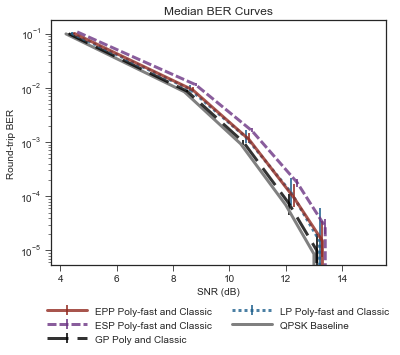

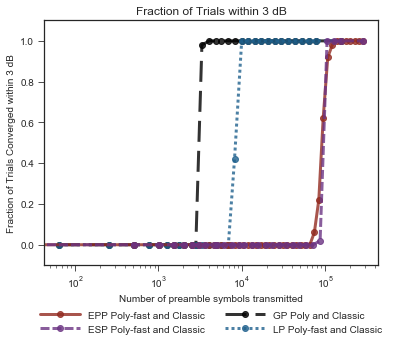

In [11]:
must_include = ['QPSK','poly', 'classic' ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'clone', 'selfalien'] + ["_"+str(i) for i in range(20)] 
                +['_low','high','slow'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4, keep_protocol=True,
                             right=300*512,
                             titletext="allproto-poly-classic")

## Plot 7

gradient_passing_QPSK_neural_gp_vs_neural_gp.npy
neural_gp_vs_neural_gp
gradient_passing gradient_passing_QPSK_neural_gp_vs_neural_gp 8.4
loss_passing_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
loss_passing loss_passing_QPSK_neural_fast_vs_neural_fast 8.4
private_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
private_preamble private_preamble_QPSK_neural_fast_vs_neural_fast 8.4
shared_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
shared_preamble shared_preamble_QPSK_neural_fast_vs_neural_fast 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


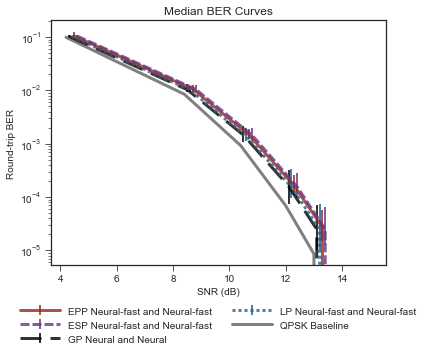

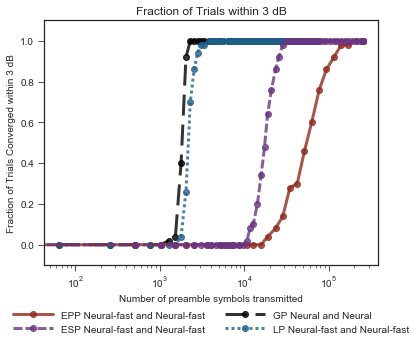

In [12]:
must_include = ['QPSK','neural' ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'clone', 'selfalien'] + ["_"+str(i) for i in range(20)] 
                +['classic', 'slow','poly','_low','high','snr'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4, keep_protocol=True,
                             right=500*512,
                             titletext="allproto-neural-neural")

## Plot 8

gradient_passing_QPSK_poly_gp_vs_poly_gp.npy
poly_gp_vs_poly_gp
gradient_passing gradient_passing_QPSK_poly_gp_vs_poly_gp 8.4
loss_passing_QPSK_poly_fast_vs_poly_fast.npy
poly_fast_vs_poly_fast
loss_passing loss_passing_QPSK_poly_fast_vs_poly_fast 8.4
private_preamble_QPSK_poly_fast_vs_poly_fast.npy
poly_fast_vs_poly_fast
private_preamble private_preamble_QPSK_poly_fast_vs_poly_fast 8.4
shared_preamble_QPSK_poly_fast_vs_poly_fast.npy
poly_fast_vs_poly_fast
shared_preamble shared_preamble_QPSK_poly_fast_vs_poly_fast 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


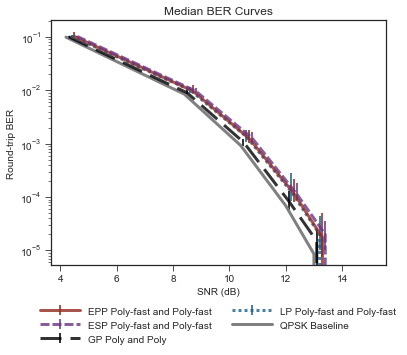

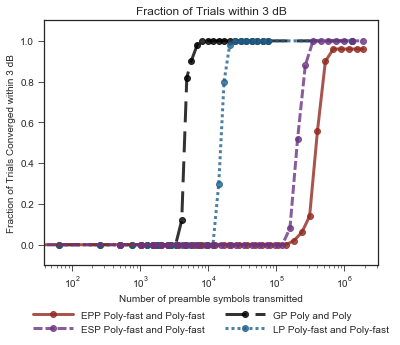

In [13]:
must_include = ['QPSK','poly', ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'clone', 'selfalien'] + ["_"+str(i) for i in range(20)] 
                +['classic', 'slow','neural','_low', 'high', 'slow'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4, keep_protocol=True,
                             right=2500*512,
                             titletext="allproto-poly-poly")

## Plot 9

shared_preamble_QPSK_neural_fast_vs_classic.npy
neural_fast_vs_classic
shared_preamble shared_preamble_QPSK_neural_fast_vs_classic 8.4
shared_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
shared_preamble shared_preamble_QPSK_neural_fast_vs_neural_fast 8.4
shared_preamble_QPSK_neural_fast_vs_poly_fast.npy
neural_fast_vs_poly_fast
shared_preamble shared_preamble_QPSK_neural_fast_vs_poly_fast 8.4
shared_preamble_QPSK_poly_fast_vs_classic.npy
poly_fast_vs_classic
shared_preamble shared_preamble_QPSK_poly_fast_vs_classic 8.4
shared_preamble_QPSK_poly_fast_vs_poly_fast.npy
poly_fast_vs_poly_fast
shared_preamble shared_preamble_QPSK_poly_fast_vs_poly_fast 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


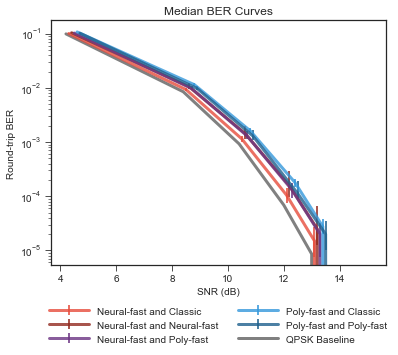

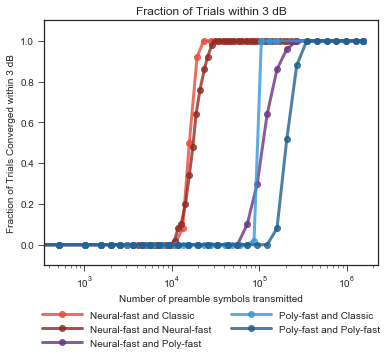

In [14]:
must_include = ['QPSK','shared', 'fast' ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['pg', 'ppo', 'clone', 'selfalien'] + ["_"+str(i) for i in range(20)] 
                +['gradient', 'slow','_low','high'])
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4,right=3000*512,
                             titletext="ESP-combos")

## Plot 10

private_preamble_8PSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
Using BPS=3 for mod_order 8PSK
Using lowest SNR 13.2
private_preamble private_preamble_8PSK_neural_fast_vs_neural_fast 13.2
private_preamble_QAM16_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
Using BPS=4 for mod_order QAM16
Using lowest SNR 15
private_preamble private_preamble_QAM16_neural_fast_vs_neural_fast 15
private_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
Using BPS=2 for mod_order QPSK
Using lowest SNR 8.4
private_preamble private_preamble_QPSK_neural_fast_vs_neural_fast 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


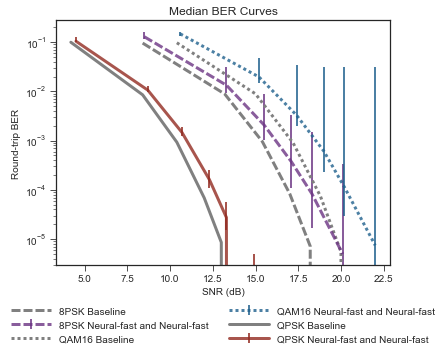

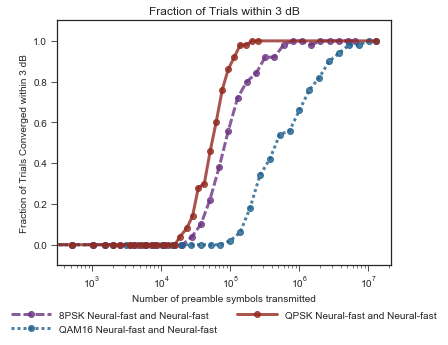

In [15]:
must_include = ['private', 'neural', 'fast' ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['_pg', '_ppo', 'clone', 'selfalien'] #+ ["_"+str(i) for i in range(20)] 
                +['poly', 'slow', 'classic','_low','high'])
plot_ber_and_fraction_trials(must_include, must_exclude, log_scale=True, keep_order=True,
                             titletext="EPP-mod-orders")

shared_preamble_8PSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
Using BPS=3 for mod_order 8PSK
Using lowest SNR 13.2
shared_preamble shared_preamble_8PSK_neural_fast_vs_neural_fast 13.2
shared_preamble_QAM16_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
Using BPS=4 for mod_order QAM16
Using lowest SNR 15
shared_preamble shared_preamble_QAM16_neural_fast_vs_neural_fast 15
shared_preamble_QPSK_neural_fast_vs_neural_fast.npy
neural_fast_vs_neural_fast
Using BPS=2 for mod_order QPSK
Using lowest SNR 8.4
shared_preamble shared_preamble_QPSK_neural_fast_vs_neural_fast 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


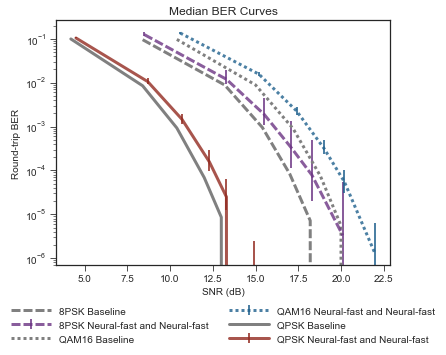

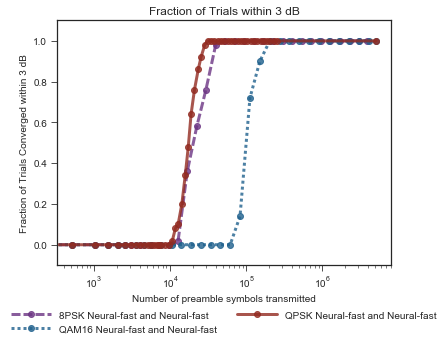

In [16]:
must_include = ['shared', 'neural', 'fast' ]#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = (['_pg', '_ppo', 'clone', 'selfalien'] #+ ["_"+str(i) for i in range(20)] 
                +['poly', 'slow', 'classic','_low','high','snr'])
plot_ber_and_fraction_trials(must_include, must_exclude, log_scale=True, keep_order=True,
                             titletext="ESP-mod-orders")

## Plot 11

private_preamble_QPSK_neural_vs_neural_high_snr.npy
neural_vs_neural_high_snr
Using BPS=2 for mod_order QPSK
Using lowest SNR 13
private_preamble private_preamble_QPSK_neural_vs_neural_high_snr 13
private_preamble_QPSK_neural_vs_neural_low_snr.npy
neural_vs_neural_low_snr
Using BPS=2 for mod_order QPSK
Using lowest SNR 4.2
private_preamble private_preamble_QPSK_neural_vs_neural_low_snr 4.2
private_preamble_QPSK_neural_vs_neural_mid_snr.npy
neural_vs_neural_mid_snr
Using BPS=2 for mod_order QPSK
Using lowest SNR 8.4
private_preamble private_preamble_QPSK_neural_vs_neural_mid_snr 8.4


/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:233: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/jsanz/.venvs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:235: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


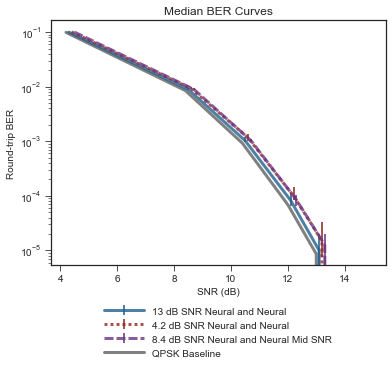

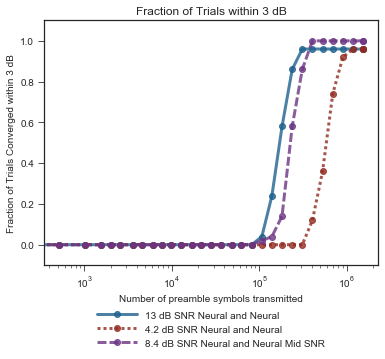

In [17]:
must_include = ['QPSK', 'private', 'neural', 'snr' ]
must_exclude = ['_pg', '_ppo', 'clone', 'selfalien', 'fast']
plot_ber_and_fraction_trials(must_include, must_exclude, log_scale=True, keep_snr=True,right=3000*512,
                             titletext="EPP-train-SNRs")

In [18]:
raise RuntimeError("Stop here unless working with MAML")

RuntimeError: Stop here unless working with MAML

# Small No MAML

## QPSK

In [ ]:
must_include = ['QPSK']
must_exclude = ['local']
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4)

## QAM16

In [ ]:
must_include = ['QAM16','loss', 'small']#, 'small']#['selfalien']#['shared', '8_4']
must_exclude = ['clone', 'neural']#['poly', 'selfalien']
plot_ber_and_fraction_trials(must_include, must_exclude, 4, log_scale=True, snr=15)

# Large MAML

## QPSK

In [ ]:
must_include = ['QPSK', 'loss', 'large']
must_exclude = ['local', 'classic']
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4)

## QAM16

In [ ]:
must_include = ['QAM16', 'loss', 'large']
must_exclude = ['local', 'classic']
plot_ber_and_fraction_trials(must_include, must_exclude, 4, log_scale=True, snr=15)

# All

## QPSK

In [ ]:
must_include = ['QPSK', 'loss']
must_exclude = ['local', 'classic', 'neural']
plot_ber_and_fraction_trials(must_include, must_exclude, 2, log_scale=True, snr=8.4)

## QAM16

In [ ]:
must_include = ['QAM16', 'loss']
must_exclude = ['local', 'classic', 'neural']
plot_ber_and_fraction_trials(must_include, must_exclude, 4, log_scale=True, snr=15)

# Constellations

In [ ]:
#Analyzing Private Preamble
from utils.util_data import get_grid_2d
def visualize_demod_grid(demod_grid):
    plt.scatter(grid[:,0], grid[:,1], c = demod_grid)
    for c in np.unique(demod_grid):
        cur_grid = grid[demod_grid == c, :]
        plt.annotate(c, (cur_grid[cur_grid.shape[0]//2, 0], cur_grid[cur_grid.shape[0]//2, 1]))
        plt.scatter(cur_grid[:,0], cur_grid[:,1])
#           plt.scatter(constellation[:, 0], constellation[:, 1])
    plt.gca().set_aspect('equal')
    plt.show()

    
def visualize_constellation(constellation):
    for c in range(constellation.shape[0]):
        plt.scatter(constellation[c,0], constellation[c,1])
        plt.annotate(c, (constellation[c,0], constellation[c,1]))
    plt.show()
    
    
grid = get_grid_2d(grid=[-1.5, 1.5], points_per_dim=100)
# resultdir = "../experiments/private_preamble/QPSK_classic_and_poly_vs_classic_pg/results/"
# resultdir = "../experiments/private_preamble/QPSK_poly_vs_poly_pg/results/"
# resultdir = "../experiments/private_preamble/QPSK_poly_vs_neural_pg/results/"
resultdir = "../experiments/private_preamble/QPSK_neural_vs_neural_pg/results/"

for i in range(40):
    print("Job ", i)
    resultfile = resultdir + "{}.npy".format(i)
    results = np.load(resultfile, allow_pickle=True)
    
#     for j in range(1,len(results)):
    for j in range(len(results)-1,len(results)):

        print(j)
        res = results[j]
        print(res.keys())
        test_bers = res['test_bers']
        mod_std_2 = res['mod_std_2']
        mod_std_1 = res['mod_std_1']
        print("Demod 1")
        demod_grid_1 = res['demod_grid_1']
        visualize_demod_grid(demod_grid_1)
        print(test_bers)
        
        print("Mod 1", mod_std_1)
        mod1 = res['constellation_1']
        visualize_constellation(mod1)
        
        print("Demod 2")
        demod_grid_2 = res['demod_grid_2']
        visualize_demod_grid(demod_grid_2)
        print(test_bers)
        
        print("Mod 2", mod_std_2)
        mod2 = res['constellation_2']
        visualize_constellation(mod2)
        
        
#         plt.scatter(mod2[:,0], mod2[:,1])
#         plt.show()
#         print(demod_grid)
#      

# ???

In [ ]:
from compile_results import process_experiment
from pprint import pprint
import numpy as np
# import os
# os.listdir("./")
# process_experiment("./")
meta, r1 = np.load('20190813_040500_0.npy')[0], np.load('20190813_040500_0.npy')[1:]
r2 = np.load('20190813_040906_0.npy')[1:]
nequal = False
for i,j in zip(r1, r2):
    if i.keys() != j.keys():
        print("keys not eq ", i.keys(), j.keys())
        break
    for k in i.keys():
        nequal =  i[k]!=j[k]
        if isinstance(nequal, np.ndarray):
            nequal = np.any(nequal)
        if nequal:
            pprint(i[k])
            pprint(j[k])
            break
    if nequal:
        break

process_experiment("./")

In [ ]:
br = utils.util_lookup_table.BER_lookup_table()
color = {
 'QPSK_neural_vs_clone':"r",
 'QPSK_neural_vs_selfalien':'g',
 'QPSK_neural_vs_poly':'b',
 'QPSK_classic_and_neural':"orange",
 'QPSK_poly_vs_clone':"blue",
}
fig,(ber, db3, db5) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(6*3)
# for ax in axes:
#     ax.set_aspect('equal', adjustable="datalim")
# (ber, db3, db5) = axes
fig.suptitle('QPSK')
baseline=False

#     f = os.path.join("./results", experiment_name)
experiment_name = meta['experiment_name']
experiment_dict = process_experiment("./")
print(experiment_dict.keys())
mid_ber = sorted(experiment_dict.keys())[0]
r = experiment_dict[mid_ber]
print(r.keys())
#     print(r['test_SNR_dbs'], np.fliplr(np.array(r['BER_mid']).reshape((1, 6))))
# ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
#           np.fliplr(np.array(r['BER_mid']).reshape((1, 6)))[0],'o-b', 
#           label=experiment_name, color = color[experiment_name], linewidth = 3)
db3.plot(r['symbols_sent'], r['3db_off'],'o-b',  label=experiment_name, color = color[experiment_name], linewidth = 3, alpha=.5)
db5.plot(r['symbols_sent'], r['5db_off'], 'o-b',label=experiment_name, color = color[experiment_name], linewidth = 3, alpha=.5)
if not baseline:
    ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, 2) 
                    for test_SNR_db in np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0]]
    ber.plot( np.fliplr(np.array(r['test_SNR_dbs']).reshape((1, 6)))[0], 
          ber_baseline,'o-b',
          label="baseline", color ='gray', linewidth = 3)
    baseline=True
ber.set_aspect('equal')
ber.set_yscale('log')
# ber.legend()

db3.set_ylim(top=1.1, bottom=-0.1)
db5.set_ylim(top=1.1, bottom=-0.1)
# db5.set_aspect('equal')
handles, labels = ber.get_legend_handles_labels()



# Put a legend below current axis
fig.legend(handles,                # The line objects
           labels,
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title",  # Title for the legend
           loc='lower center',
           fancybox=True, shadow=True, ncol=5
           )
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2)  
plt.show()

In [ ]:
# plt.plot(ebnodb, psk81)
# plt.plot(ebnodb, qpsk1)
# plt.plot(ebnodb, qam161)
# plt.plot(test_SNR_dbs, psk8)
# plt.plot(test_SNR_dbs, qpsk)
# plt.plot(test_SNR_dbs, qam16)
# plt.xlabel("Eb/N0")
# plt.ylabel("BER")
# plt.yscale('log')
# plt.ylim(10e-9, 10e-1)
# plt.xlim(4, 16)
# plt.show()
# %BPSK BER
# const=[1 -1];
# size=100000;
# iter_max=1000;
# EbN0_min=0;
# EbN0_max=10;
# SNR=[];BER=[];
# for EbN0 = EbN0_min:EbN0_max
# EbN0_lin=10.^(0.1*EbN0);
# noise_var=0.5/(EbN0_lin); % s^2=N0/2
# iter = 0;
# err = 0;
# while (iter <iter_max && err <100),
# bits=randsrc(1,size,[0 1]);
# s=const(bits+1);
# ;
# bit_hat=(-sign(x)+1)/2;
# err = err + sum(bits ~= bit_hat);
# iter = iter + 1;
# 5
# end
# SNR =[SNR EbN0];
# BER = [BER err/(size*iter)];
# end
# semilogy(SNR,BER);grid;xlabel(’E_bN_0’);ylabel(’BER’);
# title(’BPSK over AWGN channel’);

In [ ]:
# plt.rcParams["font.family"] = "Times New Roman"
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams.update({'xtick.labelsize' : 15, 'ytick.labelsize' : 15, 'axes.labelsize':15, 'legend.fontsize':15})
# plt.rcParams["figure.figsize"] = [16,10]
matplotlib.rc('font', size=30)
color = [0,0,"red","green","blue"]
label = [0,0,"QPSK","8PSK","QAM16"]
for bps in [2,3,4]:
    test_SNR_dbs = list(utils.util_data.get_test_SNR_dbs()[bps]['ber_roundtrip'])
    test_SNR_dbs.reverse()
    ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, bps) 
         for test_SNR_db in np.array(test_SNR_dbs)]
    plt.plot(test_SNR_dbs, ber_baseline,  marker='o',label=label[bps])
plt.xlabel("SNR(dB)")
plt.ylabel("Round-trip BER")
plt.yscale('log')
plt.legend()
# plt.title("Round-trip BER Curves")

plt.show()

In [ ]:
bps=2
# plt.style.use('seaborn')
test_SNR_dbs = list(utils.util_data.get_test_SNR_dbs()[bps]['ber_roundtrip'])
test_SNR_dbs.reverse()
ber_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db, bps) for test_SNR_db in np.array(test_SNR_dbs)]
# ber3_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-3, bps) for test_SNR_db in np.array(test_SNR_dbs)]
# ber5_baseline = [br.get_optimal_BER_roundtrip(test_SNR_db-5, bps) for test_SNR_db in np.array(test_SNR_dbs)]
plt.plot(test_SNR_dbs, ber_baseline,  marker='o',label='baseline')
plt.scatter(8.4,br.get_optimal_BER_roundtrip(8.4-3, bps), color='red')
plt.gca().annotate('test BER', xy=(8.4,br.get_optimal_BER_roundtrip(8.4-3, bps)), 
                   xytext=(0.8, 0.8), textcoords='axes fraction',
                   horizontalalignment='right', verticalalignment='top',
            arrowprops=dict(facecolor='black', shrink=0.05),fontsize =18
            )
plt.axvline(x=8.4, ymin=0, ymax=1, linestyle='dotted', color='gray')
plt.axhline(y=0.0095, linestyle='dotted', color='gray')
pair_x = (8.4,5.3)
pair_y = (br.get_optimal_BER_roundtrip(8.4-3, bps), br.get_optimal_BER_roundtrip(8.4-3, bps))
plt.plot(pair_x, pair_y, 'red', marker='o', linewidth=2)
plt.gca().annotate('dB off', xy=(6.0,.1), textcoords='axes fraction', xytext=(.25,.92) ,fontsize =18, color='red')
# plt.plot(test_SNR_dbs, ber3_baseline,label='3db off')
# plt.plot(test_SNR_dbs, ber5_baseline,label='5db off')

plt.xlabel("SNR(dB)")
plt.ylabel("Round-trip BER")
plt.yscale('log')
plt.ylim(top=.2)
plt.xlim(right=14.2)
plt.legend()